<a href="https://colab.research.google.com/github/maximmillion/ConvolutionExp/blob/main/Bin_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
fr2om tensorflow.keras.callbacks import History 
from keras.models import Sequential
from tensorflow.keras import layers

from random import randint
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Making the dataset:

In [ ]:
# Create 250 squares
NUM_SQUARES = 250
WIDTH = 128

X_train = []
for i in range(NUM_SQUARES):
    exp = np.zeros((WIDTH, WIDTH)) #  128*128 canvas 
    x_start = randint(0, WIDTH - 1)
    x_end = randint(x_start, WIDTH)
    y_start = randint(0, WIDTH - 1)
    y_end = randint(y_start, WIDTH)
    for x in range(y_start, y_end):
        for y in range(y_start, y_end):
            exp[x, y] = 1
    X_train.append(exp)

In [ ]:
# Create 250 circles
for i in range(NUM_SQUARES):
    x = np.arange(0, WIDTH)
    y = np.arange(0, WIDTH)
    arr = np.zeros((y.size, x.size))

    cx = randint(0, WIDTH)
    cy = randint(0, WIDTH)
    r = randint(0, WIDTH / 2)

    # The two lines below could be merged, but I stored the mask
    # for code clarity.
    mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
    arr[mask] = 1
    if randint(0, 1) == 0: # sometie true
        arr = np.fliplr(arr)
    X_train.append(arr)
print(len(X_train))

500


In [ ]:
Y_train = np.array([1 if i < NUM_SQUARES else 0 for i in range(NUM_SQUARES * 2)])

In [ ]:
# Shuffle training data
shuffler = np.random.permutation(NUM_SQUARES*2)

X_train = np.array(X_train)

shufled_X_train = X_train[shuffler]
shufled_Y_train = Y_train[shuffler]

1


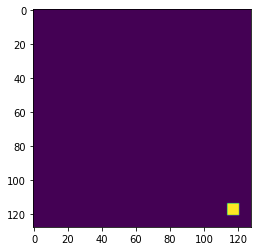

In [ ]:
print(shufled_Y_train[100])
plt.imshow(shufled_X_train[100])

## Splitting the data:

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train,
                                                    stratify=Y_train, 
                                                    test_size=0.2)

print(x_train.shape)
print(x_test.shape)

(400, 128, 128)
(100, 128, 128)


In [ ]:
# Reshaping as per requirement

x_wanted_train = x_train.reshape(len(x_train), WIDTH, WIDTH, 1)
x_wanted_test = x_test.reshape(len(x_test), WIDTH, WIDTH, 1)

## Augmenting the data:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [ ]:
datagen.fit(x_wanted_train)

# Model Work: 

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
# Adding some extra layers before the input to deal with a single channel image
# resnet takes a 3 channel input
img_input = layers.Input(shape=(WIDTH, WIDTH, 1))
img_conc = layers.Concatenate()([img_input, img_input, img_input])

# Load model without classifier/fully connected layers
# the top 3 layers are the fully connected dense layers when we say include_top = False
# it means we don't want them, we only want the Convolutional layers
resnet_model = ResNet50(input_tensor=img_conc, weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet_model.summary()  #Trainable parameters will be 0

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 128, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['concatenate[0][0]']     

In [ ]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in resnet_model.layers:
    #if not layer.name.startswith('conv5_block3_3'):
    layer.trainable = False

## Creating the model:

In [ ]:
INPUT_SHAPE = (WIDTH, WIDTH)   

model = Sequential()
# to add the extra dimesion in the image
#model.add(layers.Reshape((WIDTH, WIDTH, 1), input_shape=INPUT_SHAPE))
# using the renset CNN with learned features, only learninf in con_5 block_3
model.add(resnet_model)
# flattening the multiple dimension output from the CNN
#model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
# model.add(layers.Dense(5000, activation='relu'))
# model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1000)              32769000  
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 56,357,713
Trainable params: 32,770,001
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(1e-4), 
              metrics=['accuracy'])

## Training the model

In [ ]:
from keras.callbacks import EarlyStopping
# instroducing early stopping
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)


history = model.fit(datagen.flow(x_wanted_train, y_train, batch_size=32,
         subset='training'),
         validation_data=(x_wanted_test, y_test),
        callbacks=[early_stopping_monitor],
#          steps_per_epoch=len(x_train) // 32, 
#         validation_steps = len(x_train) // 8,
        epochs=10)

Epoch 1/10
10/10 [==============================] - 29s 3s/step - loss: 0.3454 - accuracy: 0.8219 - val_loss: 0.5991 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 24s 2s/step - loss: 0.2261 - accuracy: 0.9000 - val_loss: 0.5489 - val_accuracy: 0.6400
Epoch 3/10
10/10 [==============================] - 23s 2s/step - loss: 0.1866 - accuracy: 0.9187 - val_loss: 0.6255 - val_accuracy: 0.6100
Epoch 4/10
10/10 [==============================] - 24s 2s/step - loss: 0.1827 - accuracy: 0.9187 - val_loss: 0.4442 - val_accuracy: 0.9000
Epoch 5/10
10/10 [==============================] - 24s 2s/step - loss: 0.1749 - accuracy: 0.9219 - val_loss: 0.7145 - val_accuracy: 0.5900
Epoch 6/10
10/10 [==============================] - 24s 2s/step - loss: 0.1495 - accuracy: 0.9344 - val_loss: 0.4447 - val_accuracy: 0.8900
Epoch 7/10
10/10 [==============================] - 24s 2s/step - loss: 0.1766 - accuracy: 0.9094 - val_loss: 0.4602 - val_accuracy: 0.7900


## Visualizing Results:

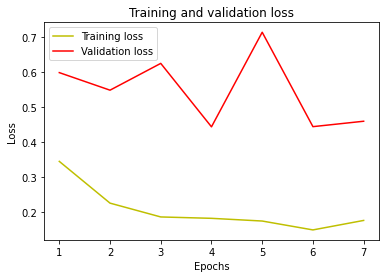

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

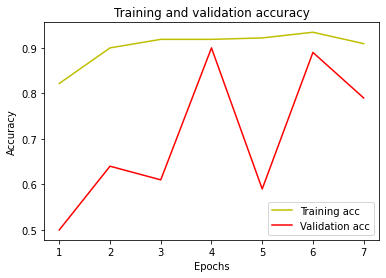

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Taking a prediction:

The prediction for this image is:  1
The actual label for this image is:  1


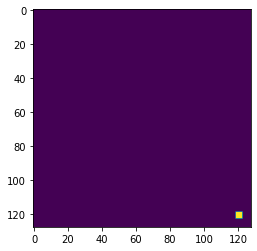

In [ ]:
n = 16  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)

input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y)

print("The prediction for this image is: ", round(model.predict(input_img)[0][0]))
print("The actual label for this image is: ", y_test[n])

## Confusion Matrix:

In [ ]:
pred = np.round(model.predict(x_test))
pred = np.array(list(map(lambda x: x[0], pred))) 

In [ ]:
def showconfusionmatrix(cm):
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.show()

[[40 10]
 [ 0 50]]


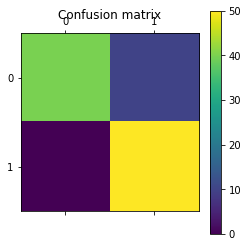

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
print (cm)

showconfusionmatrix(cm)